In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
df= pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [6]:
df.shape

(7588, 2)

In [8]:
df.isnull().sum()   # no missing values

date       0
Ex_rate    0
dtype: int64

In [10]:
df.duplicated().sum()  # no dulplicates

0

In [12]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


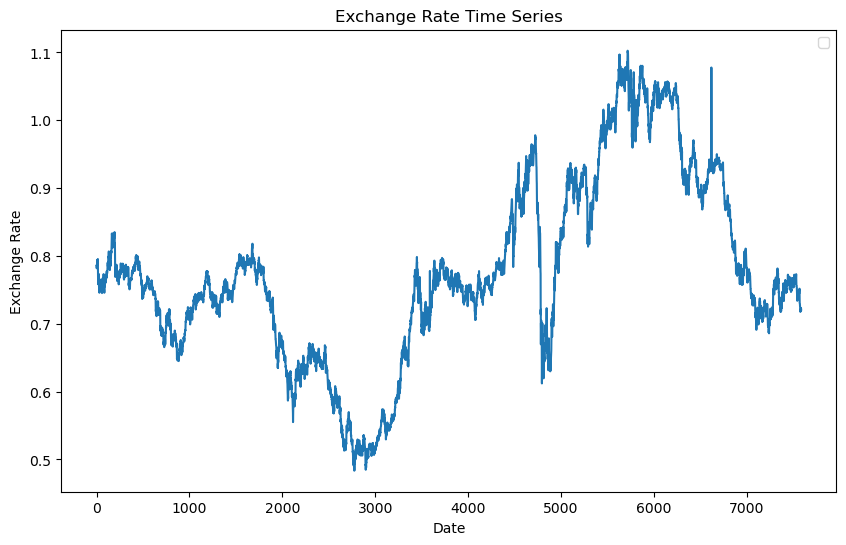

In [14]:
plt.figure(figsize=(10,6))
plt.plot(df.index,df['Ex_rate'])
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

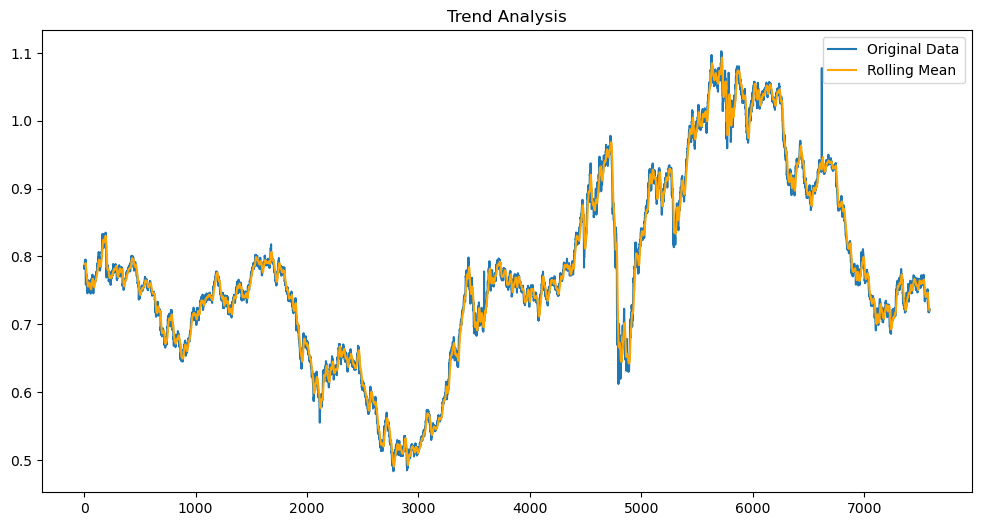

In [16]:
df['Rolling_Mean']= df['Ex_rate'].rolling(window=12).mean()
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'],label= 'Original Data')
plt.plot(df.index,df['Rolling_Mean'],label= 'Rolling Mean',color= 'orange')
plt.title('Trend Analysis')
plt.legend()
plt.show()

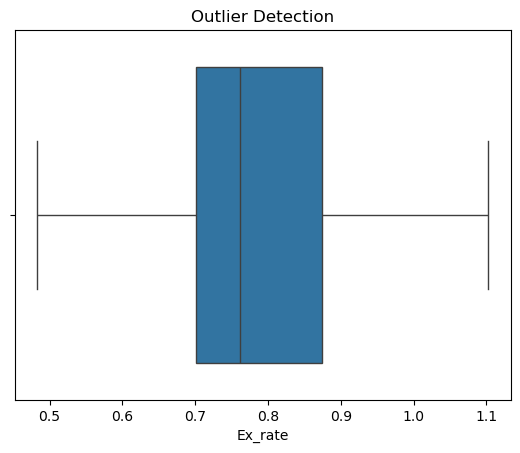

In [18]:
sns.boxplot(x=df['Ex_rate'])
plt.title('Outlier Detection')
plt.show()

In [22]:
Q1= df['Ex_rate'].quantile(0.25)   # replacing outliers using IQR method
Q3= df['Ex_rate'].quantile(0.75)
IQR= Q3-Q1
lower_bound= Q1-1.5*IQR
upper_bound= Q3+1.5*IQR
df.loc[df['Ex_rate']<lower_bound,'Ex_rate']= df['Rolling_Mean']
df.loc[df['Ex_rate']>upper_bound,'Ex_rate']= df['Rolling_Mean']

In [24]:
IQR

0.17205499999999996

In [26]:
lower_bound

0.44333950000000005

In [28]:
upper_bound

1.1315594999999998

In [30]:
from statsmodels.tsa.stattools import adfuller

In [34]:
adf_test= adfuller(df['Ex_rate'].dropna())
print(f'ADF Statistics: {adf_test[0]}')

ADF Statistics: -1.6649941807381343


In [36]:
print(f'p=value: {adf_test[1]}')

p=value: 0.44923273535979974


## ARIMA model building

In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

In [41]:
diff_series= df['Ex_rate'].diff().dropna()
diff_series

1      -0.003700
2       0.004900
3      -0.000700
4      -0.001100
5       0.001700
          ...   
7583   -0.000207
7584    0.003345
7585    0.001358
7586   -0.002372
7587    0.000000
Name: Ex_rate, Length: 7587, dtype: float64

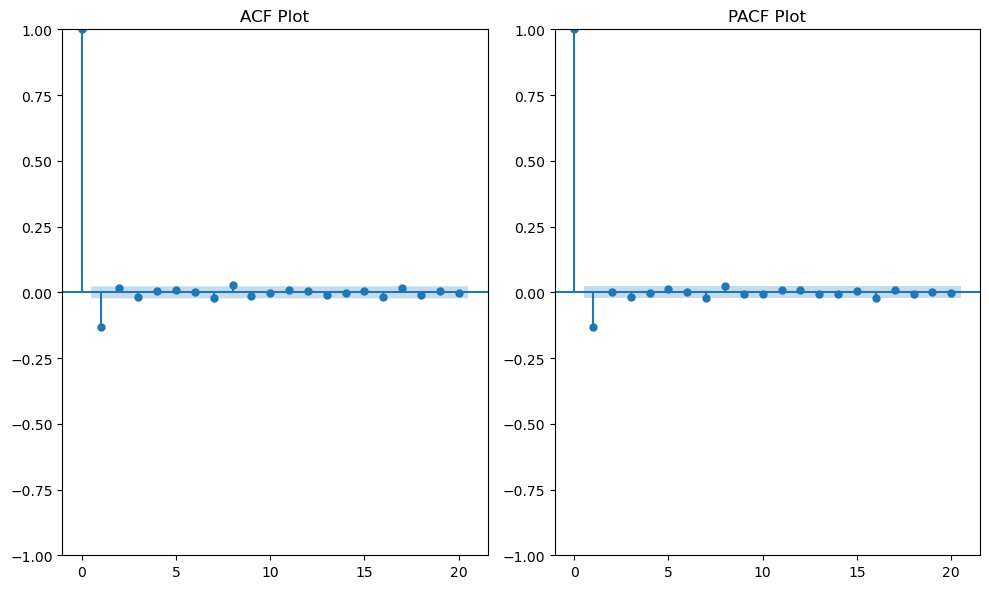

In [43]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plot_acf(diff_series,ax=plt.gca(),lags=20)
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(diff_series,ax=plt.gca(),lags=20)
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

In [51]:
p,d,q=2,1,1
model= ARIMA(df['Ex_rate'],order=(p,d,q))

In [53]:
model_fit= model.fit()

In [55]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 1)   Log Likelihood               28054.158
Date:                Sun, 23 Feb 2025   AIC                         -56100.316
Time:                        17:37:13   BIC                         -56072.579
Sample:                             0   HQIC                        -56090.797
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0654      0.001    -60.675      0.000      -0.068      -0.063
ar.L2          0.0084      0.006      1.414      0.157      -0.003       0.020
ma.L1         -0.0661      0.001    -59.638      0.0

In [61]:
residuals= model_fit.resid

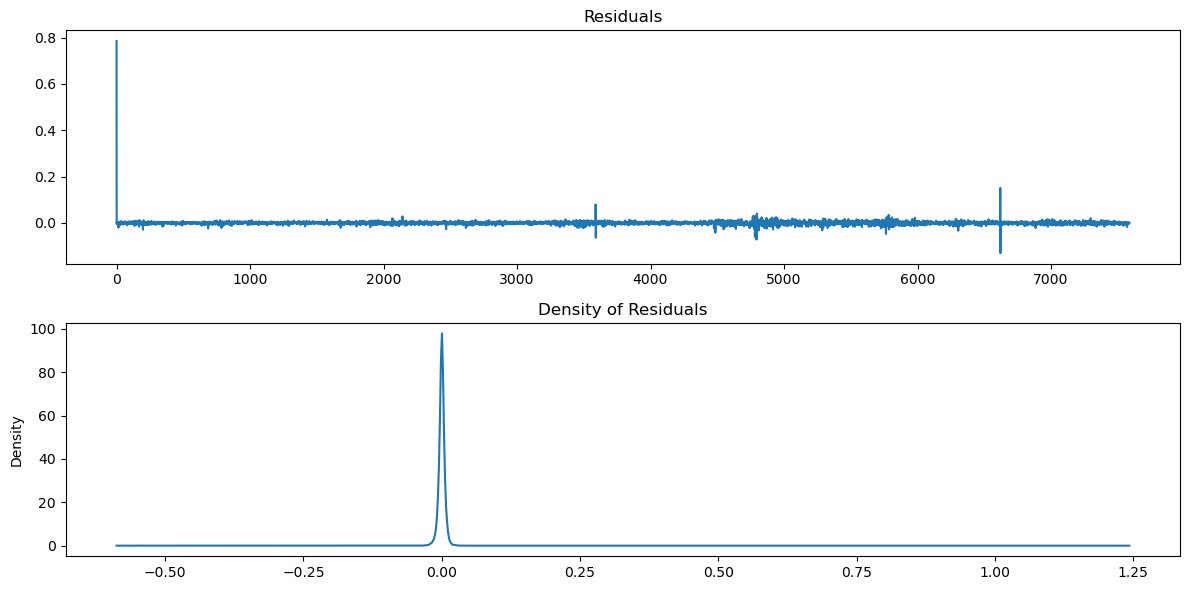

In [63]:
plt.figure(figsize=(12,6))
plt.subplot(211)
residuals.plot(title='Residuals',ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde',title='Density of Residuals',ax=plt.gca())
plt.tight_layout()
plt.show()

In [65]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [69]:
ljungbox_test= acorr_ljungbox(residuals,lags=[10],return_df=True)
print(ljungbox_test)

     lb_stat  lb_pvalue
10  1.809985     0.9976


In [81]:
forecast= model_fit.get_forecast(steps=10)
forecast_values= forecast.predicted_mean
conf_int= forecast.conf_int()

In [83]:
forecast

In [85]:
forecat_values

7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
Name: predicted_mean, dtype: float64

In [87]:
conf_int

,lower Ex_rate,upper Ex_rate
7588,0.709083,0.732569
7589,0.705272,0.736379
7590,0.702117,0.739535
7591,0.699434,0.742217
7592,0.697051,0.744601
7593,0.694886,0.746766
7594,0.692888,0.748764
7595,0.691024,0.750628
7596,0.689269,0.752382
7597,0.687608,0.754044


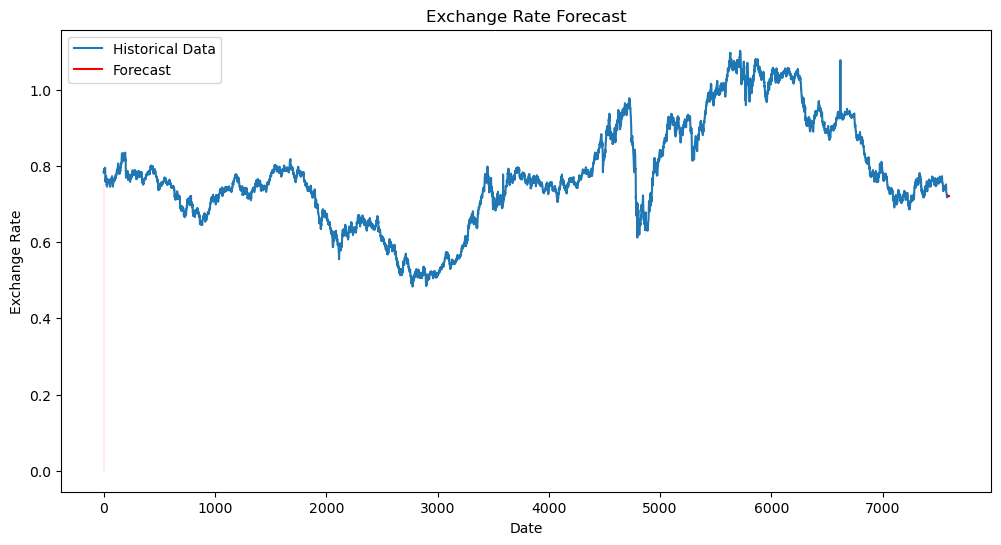

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_values, label='Forecast', color='red')
plt.fill_between(conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error

In [93]:
test_data= df[-10:]
aligned_forecast_values= forecast_values[:len(test_data)]
rmse= mean_squared_error(test_data['Ex_rate'],aligned_forecast_values)**0.5

In [95]:
test_data

,date,Ex_rate,Rolling_Mean
7578,01-10-2010 00:00,0.717618,0.732462
7579,02-10-2010 00:00,0.719114,0.729976
7580,03-10-2010 00:00,0.719114,0.727429
7581,04-10-2010 00:00,0.719735,0.724769
7582,05-10-2010 00:00,0.718701,0.723494
7583,06-10-2010 00:00,0.718494,0.722488
7584,07-10-2010 00:00,0.721839,0.721832
7585,08-10-2010 00:00,0.723197,0.721288
7586,09-10-2010 00:00,0.720825,0.720813
7587,10-10-2010 00:00,0.720825,0.720460


In [97]:
aligned_forecast_values

7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
Name: predicted_mean, dtype: float64

In [99]:
rmse

0.0018422960100057174

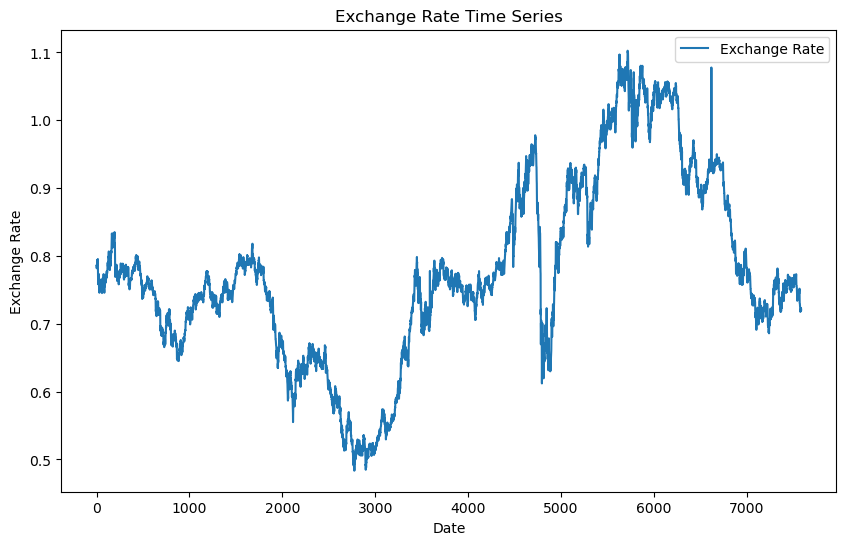

In [101]:
## Model building
plt.figure(figsize=(10,6))
plt.plot(df['Ex_rate'],label='Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [103]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [105]:
ses_model= SimpleExpSmoothing(df['Ex_rate']).fit(optimized=True)
ses_model

In [107]:
print(f'Optimal alpha: {ses_model.model.params['smoothing_level']}')

Optimal alpha: 0.8683720930232558


In [109]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [111]:
holt_model= ExponentialSmoothing(df['Ex_rate'],trend='add').fit(optimized=True)
holt_model

In [113]:
print(f'Optimal smoothing level: {holt_model.model.params['smoothing_level']}')
print(f'Optimal trend smoothing: {holt_model.model.params['smoothing_level']}')

Optimal smoothing level: 0.8700400977539624
Optimal trend smoothing: 0.8700400977539624


In [117]:
hw_model= ExponentialSmoothing(df['Ex_rate'],trend='add',seasonal='add',seasonal_periods=12).fit(optimized=True)
hw_model

In [119]:
print(f"Optimal smoothing level: {hw_model.model.params['smoothing_level']}")
print(f"Optimal trend smoothing: {hw_model.model.params['smoothing_trend']}")
print(f"Optimal seasonal smoothing: {hw_model.model.params['smoothing_seasonal']}")

Optimal smoothing level: 0.8702083200584234
Optimal trend smoothing: 0.0
Optimal seasonal smoothing: 1.3525155144039928e-17


In [121]:
# Model fitting and Forecasting
hw_model= ExponentialSmoothing(df['Ex_rate'],trend='add',seasonal='add',seasonal_periods=12).fit(optimized=True)
hw_model

In [123]:
# forecast future values
forecast_steps= 10
forecast_values= hw_model.forecast(steps=forecast_steps)
forecast_values

7588    0.720813
7589    0.720595
7590    0.720260
7591    0.720518
7592    0.720357
7593    0.720480
7594    0.720540
7595    0.720245
7596    0.720426
7597    0.720467
dtype: float64

In [125]:
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='D')[1:]
forecast_index

DatetimeIndex(['1970-01-02 00:00:00.000007587',
               '1970-01-03 00:00:00.000007587',
               '1970-01-04 00:00:00.000007587',
               '1970-01-05 00:00:00.000007587',
               '1970-01-06 00:00:00.000007587',
               '1970-01-07 00:00:00.000007587',
               '1970-01-08 00:00:00.000007587',
               '1970-01-09 00:00:00.000007587',
               '1970-01-10 00:00:00.000007587',
               '1970-01-11 00:00:00.000007587'],
              dtype='datetime64[ns]', freq='D')

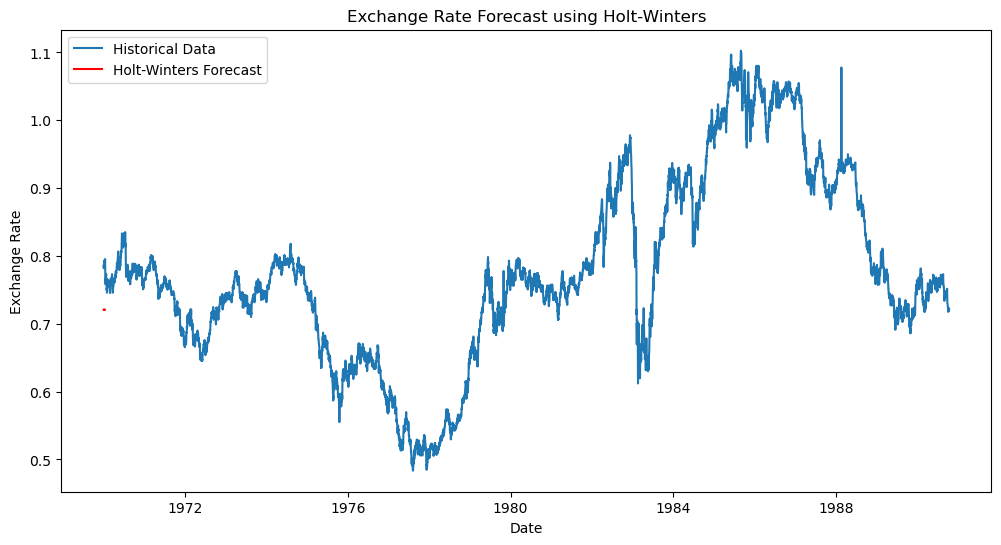

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Holt-Winters Forecast', color='red')
plt.title('Exchange Rate Forecast using Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

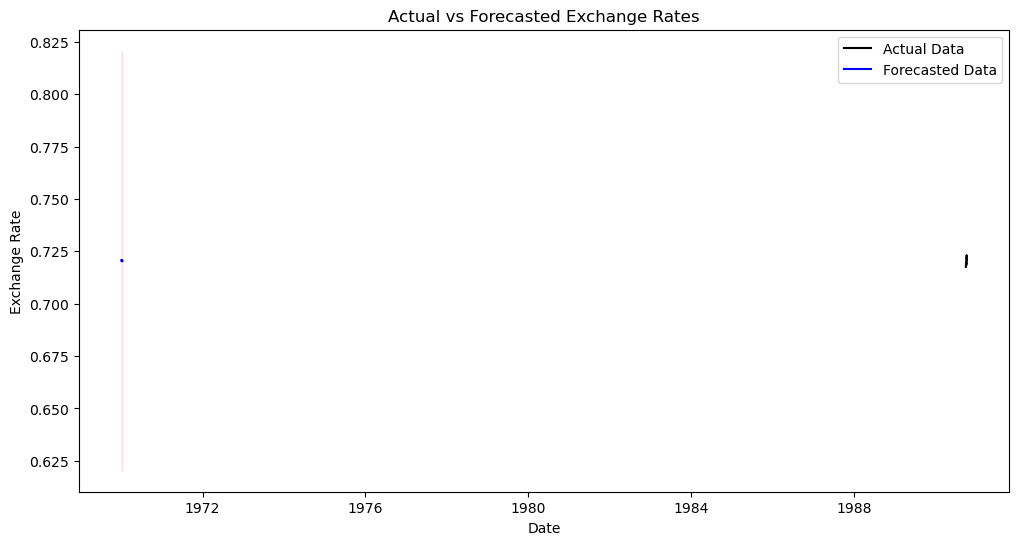

In [129]:
#comparing forecasting
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Ex_rate'], label='Actual Data', color='black')
plt.plot(forecast_index, forecast_values[:len(test_data)], label='Forecasted Data', color='blue')
plt.fill_between(forecast_index, forecast_values - 0.1, forecast_values + 0.1, color='pink', alpha=0.3)  # Confidence interval
plt.title('Actual vs Forecasted Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [131]:
# Evaluation and Comparision
from sklearn.metrics import mean_absolute_error,mean_absolute_error

In [135]:
model_arima= ARIMA(df['Ex_rate'],order=(1,1,1))
model_fit_arima= model_arima.fit()
model_arima

In [137]:
model_fit_arima

In [139]:
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 23 Feb 2025   AIC                         -56102.322
Time:                        18:26:08   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [141]:
forecast_steps = 10
forecast_arima = model_fit_arima.get_forecast(steps=forecast_steps)
# Get the forecasted mean values
forecast_values_arima = forecast_arima.predicted_mean

In [143]:
forecast_values_arima

7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
Name: predicted_mean, dtype: float64

In [145]:
aligned_forecast_arima= forecast_values_arima[:len(test_data)]
aligned_forecast_arima

7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
Name: predicted_mean, dtype: float64

In [147]:
model_hw= ExponentialSmoothing(df['Ex_rate'],trend='add',seasonal='add',seasonal_periods=12)
model_fit_hw= model_hw.fit()

In [149]:
forecast_steps = 10
forecast_hw = model_fit_hw.forecast(steps=forecast_steps)

forecast_values_hw = forecast_hw
aligned_forecast_arima = forecast_values_arima[:len(test_data)]
aligned_forecast_hw = forecast_values_hw[:len(test_data)]

In [151]:
aligned_forecast_hw

7588    0.720813
7589    0.720595
7590    0.720260
7591    0.720518
7592    0.720357
7593    0.720480
7594    0.720540
7595    0.720245
7596    0.720426
7597    0.720467
dtype: float64

In [153]:
aligned_forecast_arima

7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
Name: predicted_mean, dtype: float64

In [155]:
mae_arima = mean_absolute_error(test_data['Ex_rate'], aligned_forecast_arima)
rmse_arima = mean_squared_error(test_data['Ex_rate'], aligned_forecast_arima, squared=False)
mape_arima = (abs((test_data['Ex_rate'] - aligned_forecast_arima) / test_data['Ex_rate']).mean()) * 100

In [157]:
mae_arima

0.001556771200417284

In [159]:
rmse_arima

0.0018425706106975357

In [161]:
mape_arima

nan

In [165]:
mae_hw = mean_absolute_error(test_data['Ex_rate'], aligned_forecast_hw)
rmse_hw = mean_squared_error(test_data['Ex_rate'], aligned_forecast_hw, squared=False)
mape_hw = (abs((test_data['Ex_rate'] - aligned_forecast_hw) / test_data['Ex_rate']).mean()) * 100

In [167]:
mae_hw

0.0015255409929272434

In [169]:
rmse

0.0018422960100057174

In [171]:
mape_hw

nan

In [173]:
print(f"ARIMA Model - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}%")
print(f"Holt-Winters Model - MAE: {mae_hw}, RMSE: {rmse_hw}, MAPE: {mape_hw}%")

ARIMA Model - MAE: 0.001556771200417284, RMSE: 0.0018425706106975357, MAPE: nan%
Holt-Winters Model - MAE: 0.0015255409929272434, RMSE: 0.0017805055431377337, MAPE: nan%


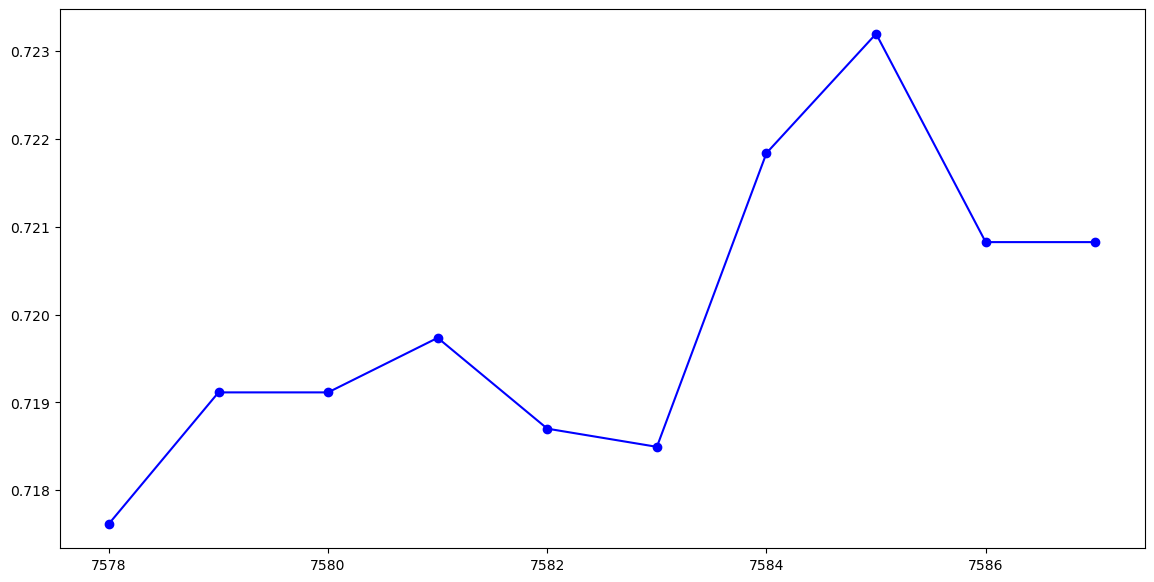

In [175]:
# Visual Comparision
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Ex_rate'], label='Actual Data', color='blue', marker='o')

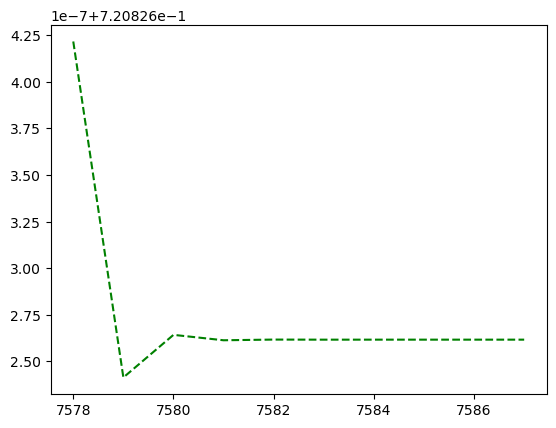

In [177]:
plt.plot(test_data.index, aligned_forecast_arima, label='ARIMA Forecast', color='green', linestyle='--')

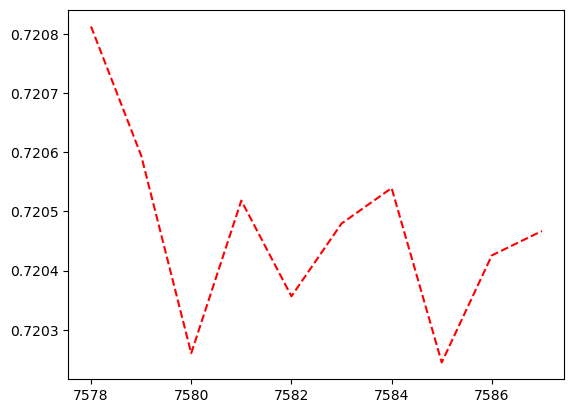

In [179]:
# Plot Holt-Winters predictions
plt.plot(test_data.index, aligned_forecast_hw, label='Holt-Winters Forecast', color='red', linestyle='--')

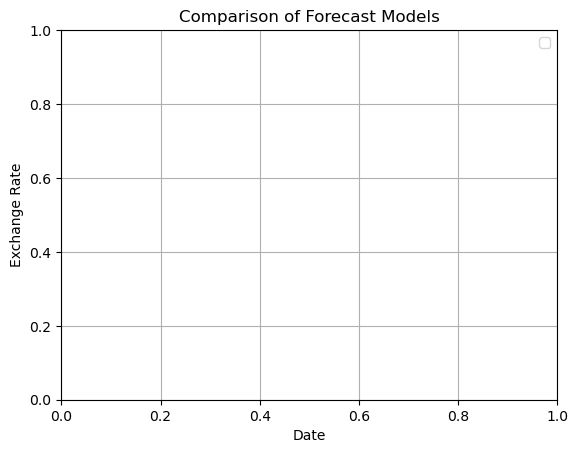

In [181]:
plt.title('Comparison of Forecast Models')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()